<a href="https://colab.research.google.com/github/bible-black/jupyterlab/blob/main/%E5%8B%89%E5%BC%B7%E4%BC%9A_4_localmodel_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib  # これで日本語OK
from scipy.optimize import minimize #パラメータ推計用

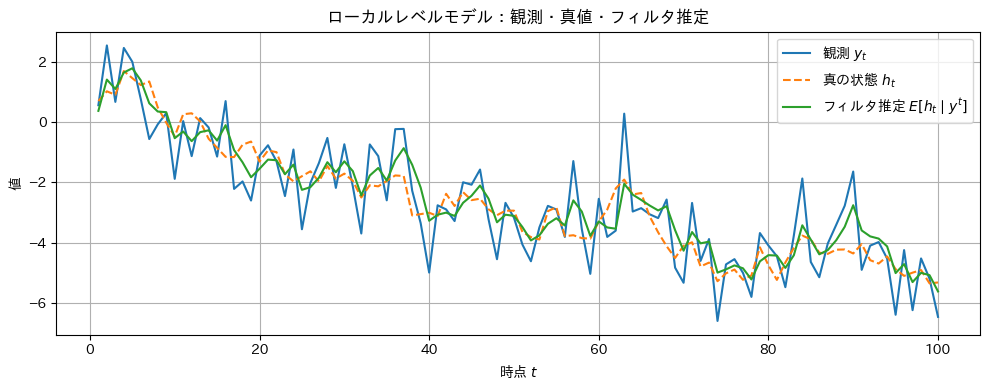

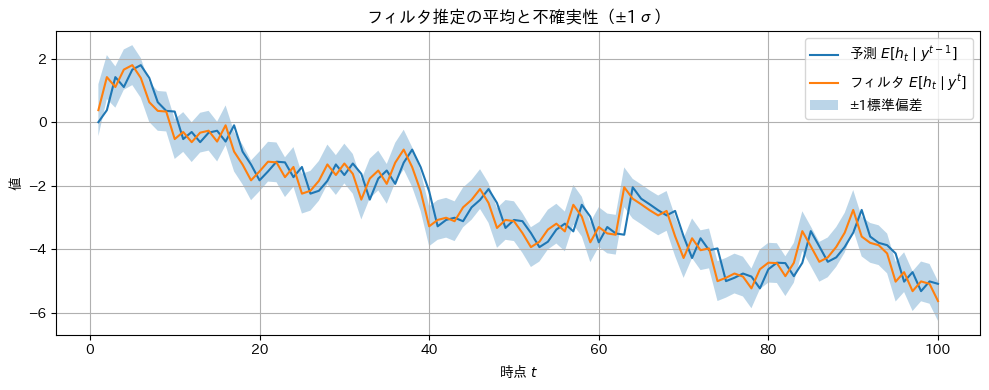

In [ ]:
# コードは「ローカルレベル（random-walk）モデル」を自分で擬似データ生成し、カルマンフィルタで隠れ状態
# ℎ𝑡を逐次推定するデモです。
# 目的:ノイズ入り観測𝑦𝑡から「本当の水準」ℎ𝑡を逐次（オンライン）で推定する。図示する。

# ----------------------------
# モデル設定（ローカルレベル）
# ----------------------------
T = 100            # 長さ
sigma = 1.0        # 観測ノイズの標準偏差
tau = 0.5          # 状態ノイズの標準偏差
a1 = 0.0           # 初期平均
P1 = 2.0           # 初期分散

# データ生成
# 擬似データ:h をランダムウォークで作り、y に観測ノイズ sigma を足して生成。
np.random.seed(42)
h = np.zeros(T + 1)
y = np.zeros(T)
h[0] = np.random.normal(a1, np.sqrt(P1))
for t in range(T):
    y[t] = h[t] + sigma * np.random.randn()
    h[t + 1] = h[t] + tau * np.random.randn()

# ----------------------------
# カルマンフィルタ
# ----------------------------
mu_pred = np.zeros(T)  # 予測平均 E[h_t | y^{t-1}]
P_pred  = np.zeros(T)  # 予測分散
mu_filt = np.zeros(T)  # フィルタ平均 E[h_t | y^t]
P_filt  = np.zeros(T)  # フィルタ分散

mu_prev = a1
P_prev  = P1
for t in range(T):
    # 予測
    mu_pred[t] = mu_prev
    P_pred[t]  = P_prev
    # 更新
    S = P_pred[t] + sigma**2
    K = P_pred[t] / S
    mu_filt[t] = mu_pred[t] + K * (y[t] - mu_pred[t])
    P_filt[t]  = (1.0 - K) * P_pred[t]
    # 次期へ
    mu_prev = mu_filt[t]
    P_prev  = P_filt[t] + tau**2

# ----------------------------
# 描画
# ----------------------------
t_axis = np.arange(1, T + 1)

plt.figure(figsize=(10, 4))
plt.plot(t_axis, y, label="観測 $y_t$")
plt.plot(t_axis, h[:-1], "--", label="真の状態 $h_t$")
plt.plot(t_axis, mu_filt, label="フィルタ推定 $E[h_t\\mid y^t]$")
plt.title("ローカルレベルモデル：観測・真値・フィルタ推定")
plt.xlabel("時点 $t$")
plt.ylabel("値")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 4))
plt.plot(t_axis, mu_pred, label="予測 $E[h_t\\mid y^{t-1}]$")
plt.plot(t_axis, mu_filt, label="フィルタ $E[h_t\\mid y^t]$")
plt.fill_between(
    t_axis,
    mu_filt - np.sqrt(P_filt),
    mu_filt + np.sqrt(P_filt),
    alpha=0.3,
    label="±1標準偏差"
)
plt.title("フィルタ推定の平均と不確実性（±1σ）")
plt.xlabel("時点 $t$")
plt.ylabel("値")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 図の読み方
# 図1：
# 青 観測 𝑦𝑡はギザギザ
# 橙破線 真の状態 ℎ𝑡（シミュレーションでの“正解”）
# 緑 フィルタ推定 𝜇𝑡∣𝑡はノイズが平均化され、真値の周りを滑らかに追従
# 図2：
# 青 予測平均𝜇𝑡∣𝑡−1 と橙 フィルタ平均 𝜇𝑡∣𝑡を比較
# 影は ±1𝜎（𝑃𝑡∣𝑡の平方根）→ 信頼帯。
# σ（観測ノイズの標準偏差）が大きいほど→ センサーは信用できない＝観測に重みをあまり置かない → 状態の線がなめらか（反応は遅い）
# 𝜏（状態ノイズの標準偏差）が大きいほど→ 真の状態がよく動くと仮定＝モデル予測を信用しすぎない → 観測に寄せて素早く追従（状態のなめらかさは下がる）

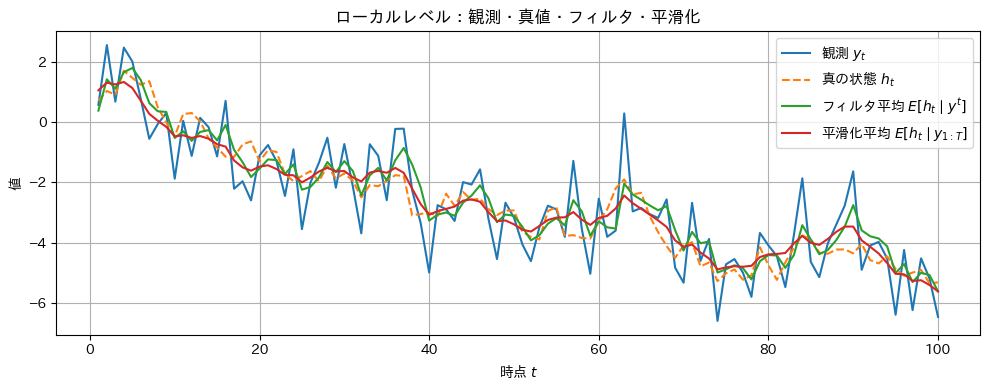

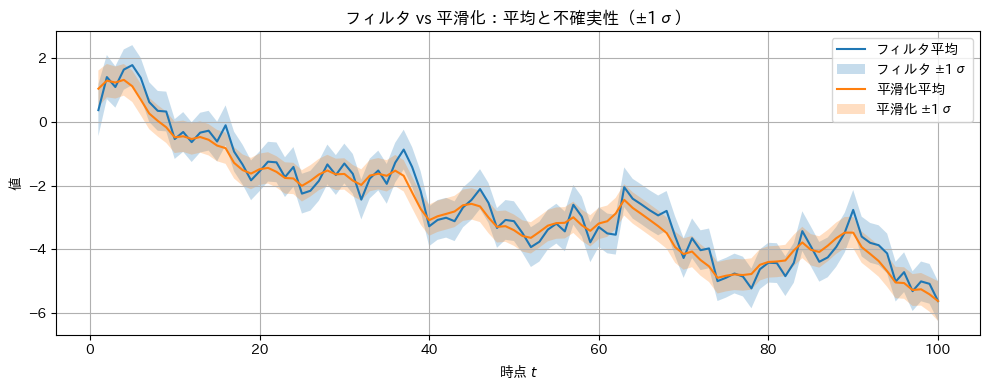

In [ ]:
# GPT5に書かせたvobe cordingのコードです
#  平滑化分布の追加（全部のyを使って過去の状態を振り返る）

# ----------------------------
# モデル設定（ローカルレベル）
# ----------------------------
T = 100            # 長さ
sigma = 1.0        # 観測ノイズの標準偏差
tau = 0.5          # 状態ノイズの標準偏差
a1 = 0.0           # 初期平均
P1 = 2.0           # 初期分散

# ----------------------------
# データ生成（真の状態 h, 観測 y）
# ----------------------------
np.random.seed(42)
h = np.zeros(T + 1)
y = np.zeros(T)
h[0] = np.random.normal(a1, np.sqrt(P1))
for t in range(T):
    y[t]   = h[t] + sigma * np.random.randn()
    h[t+1] = h[t] + tau   * np.random.randn()

# ----------------------------
# カルマンフィルタ（前向き）
# ----------------------------
mu_pred = np.zeros(T)  # 予測平均  E[h_t | y^{t-1}]
P_pred  = np.zeros(T)  # 予測分散  Var[h_t | y^{t-1}]
mu_filt = np.zeros(T)  # フィルタ平均 E[h_t | y^t]
P_filt  = np.zeros(T)  # フィルタ分散 Var[h_t | y^t]

mu_prev = a1
P_prev  = P1
for t in range(T):
    # 予測
    mu_pred[t] = mu_prev
    P_pred[t]  = P_prev
    # 観測更新
    S = P_pred[t] + sigma**2
    K = P_pred[t] / S
    mu_filt[t] = mu_pred[t] + K * (y[t] - mu_pred[t])
    P_filt[t]  = (1.0 - K) * P_pred[t]
    # 次期の予測へ（RWなので平均はそのまま、分散に tau^2 を加算）
    mu_prev = mu_filt[t]
    P_prev  = P_filt[t] + tau**2

# ----------------------------
# RTS 平滑化（後ろ向き）
#   J_t = P_{t|t} / P_{t+1|t}  （このモデルは遷移行列 = 1）
#   μ_{t|T} = μ_{t|t} + J_t (μ_{t+1|T} - μ_{t+1|t})
#   P_{t|T} = P_{t|t} + J_t^2 (P_{t+1|T} - P_{t+1|t})
# ----------------------------
mu_smooth = np.zeros(T)  # 平滑化平均 E[h_t | y_{1:T}]
P_smooth  = np.zeros(T)  # 平滑化分散 Var[h_t | y_{1:T}]

mu_smooth[-1] = mu_filt[-1]
P_smooth[-1]  = P_filt[-1]
for t in range(T-2, -1, -1):
    J = P_filt[t] / P_pred[t+1]       # smoothing gain
    mu_smooth[t] = mu_filt[t] + J * (mu_smooth[t+1] - mu_pred[t+1])
    P_smooth[t]  = P_filt[t] + J**2 * (P_smooth[t+1] - P_pred[t+1])

# ----------------------------
# 可視化
# ----------------------------
t_axis = np.arange(1, T + 1)

# 図1：真値・観測・フィルタ・平滑化の比較
plt.figure(figsize=(10, 4))
plt.plot(t_axis, y, label="観測 $y_t$")
plt.plot(t_axis, h[:-1], "--", label="真の状態 $h_t$")
plt.plot(t_axis, mu_filt, label="フィルタ平均 $E[h_t\\mid y^t]$")
plt.plot(t_axis, mu_smooth, label="平滑化平均 $E[h_t\\mid y_{1:T}]$")
plt.title("ローカルレベル：観測・真値・フィルタ・平滑化")
plt.xlabel("時点 $t$")
plt.ylabel("値")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 図2：不確実性（±1σ）：平滑化はフィルタより狭くなる
plt.figure(figsize=(10, 4))
plt.plot(t_axis, mu_filt, label="フィルタ平均")
plt.fill_between(
    t_axis,
    mu_filt - np.sqrt(P_filt),
    mu_filt + np.sqrt(P_filt),
    alpha=0.25,
    label="フィルタ ±1σ"
)
plt.plot(t_axis, mu_smooth, label="平滑化平均")
plt.fill_between(
    t_axis,
    mu_smooth - np.sqrt(P_smooth),
    mu_smooth + np.sqrt(P_smooth),
    alpha=0.25,
    label="平滑化 ±1σ"
)
plt.title("フィルタ vs 平滑化：平均と不確実性（±1σ）")
plt.xlabel("時点 $t$")
plt.ylabel("値")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# 重複になりますがもう一度、観測と状態の推移を作っておきます。（Tを変えて試したいので）
# この推移を元に、推移を作るときに使ったパラメータを推計します。
# ----------------------------
# データ生成（ローカルレベル）
# ----------------------------
T = 100000
a1 = 0.0   # 初期平均 E[h1]
P1 = 2.0   # 初期分散 Var[h1]

np.random.seed(0)
sigma_true = 1.0
tau_true   = 0.5

h = np.zeros(T + 1)
y = np.zeros(T)
h[0] = np.random.normal(a1, np.sqrt(P1))
for t in range(T):
    y[t]   = h[t] + sigma_true * np.random.randn()
    h[t+1] = h[t] + tau_true   * np.random.randn()

# ----------------------------
# 負の対数尤度（カルマンフィルタ）　#　尤度推定の準備
# ----------------------------
# パラメータ 𝜃=(𝜎2,𝜏2) を固定したとき、カルマンフィルタで
# ℓ(𝜃)=∑_{𝑡=1}^𝑇 log 𝑝(𝑦𝑡∣𝑦1:𝑡−1;𝜃)を計算

def neg_log_likelihood(params, y, a1, P1):
    sigma2, tau2 = params             # どちらも > 0（境界は bounds で保証）
    T = len(y)

    mu_prev = a1                       # E[h_t | y^{t-1}]
    P_prev  = P1                       # Var[h_t | y^{t-1}]

    nll = 0.0
    for t in range(T):
        # 1) 予測分布: y_t | y^{t-1} ~ N(mu_prev, P_prev + sigma2)
        S = P_prev + sigma2
        resid = y[t] - mu_prev
        nll += 0.5 * (np.log(2 * np.pi * S) + (resid ** 2) / S)

        # 2) 更新
        K = P_prev / S
        mu_upd = mu_prev + K * resid
        P_upd  = (1.0 - K) * P_prev

        # 3) 次期の予測へ（ランダムウォーク）
        mu_prev = mu_upd
        P_prev  = P_upd + tau2

    return nll

# ----------------------------
# 推定（L-BFGS-B, 正の制約）　#　BFGS（準ニュートン法）の亜種
# ----------------------------
init   = np.array([0.5, 0.5])                 # 初期値: [sigma^2, tau^2]
bounds = [(1e-6, None), (1e-6, None)]         # 正の制約
# 1つ目の変数：sigma2（観測ノイズ分散） ≥ 1e-6　ゼロ割を避けるため
# 2つ目の変数：tau2（状態ノイズ分散） ≥ 1e-6　ゼロ割を避けるため
# 上限はどちらも None（＝上限なし）

res = minimize(
    neg_log_likelihood,
    x0=init,
    args=(y, a1, P1),
    bounds=bounds,
    method="L-BFGS-B",
)
# res.xの戻り値 … 最適解ベクトル（今回だと array([sigma2_est, tau2_est])）

sigma2_est, tau2_est = res.x
sigma_est = np.sqrt(sigma2_est)
tau_est   = np.sqrt(tau2_est)

print(f"真の値:  sigma={sigma_true:.4f}, tau={tau_true:.4f}")
print(f"推定値:  sigma^ = {sigma_est:.4f}, tau^ = {tau_est:.4f}")
print(f"最小化成功: {res.success}, 反復回数: {res.nit}")


真の値:  sigma=1.0000, tau=0.5000
推定値:  sigma^ = 1.0015, tau^ = 0.4997
最小化成功: True, 反復回数: 8
